---

<h1 style="text-align: center;font-size: 40px;">Cataract Prediction using vgg19</h1>

---

<h3>Dataset Information:</h3>
Retina Fundus Images is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.This dataset is meant to represent ‘‘real-life’’ set of patient information collected from different hospitals/medical centers . In these institutions, fundus images are captured by various cameras in the market resulting into varied image resolutions.Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

- Normal (N),
- Cataract (C)

In [1]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras==2.6.*

In [3]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/Cataract'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
df = pd.read_csv("C:/Users/bharg/Cataract/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,64,Female,345_left.jpg,345_right.jpg,hypertensive retinopathy,hypertensive retinopathy，cataract,0,0,0,1,0,1,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['H'],"[0, 0, 0, 0, 0, 1, 0, 0]",345_left.jpg
2,2,74,Male,560_left.jpg,560_right.jpg,cataract,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",560_right.jpg


> <h3> Extracting Cataract & Normal information from the Dataset </h3>

In [5]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [6]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [7]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '560_left.jpg', '81_left.jpg', '103_left.jpg',
       '119_left.jpg', '254_left.jpg', '294_left.jpg', '330_left.jpg',
       '448_left.jpg', '465_left.jpg', '477_left.jpg', '553_left.jpg',
       '560_left.jpg', '594_left.jpg', '611_left.jpg'], dtype=object)

In [8]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['345_right.jpg', '560_right.jpg', '24_right.jpg', '81_right.jpg',
       '112_right.jpg', '188_right.jpg', '218_right.jpg', '345_right.jpg',
       '354_right.jpg', '477_right.jpg', '553_right.jpg', '560_right.jpg',
       '625_right.jpg', '726_right.jpg', '769_right.jpg'], dtype=object)

In [9]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 305
Number of images in right cataract: 292


>Normal Images

In [10]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2965_right.jpg', '685_right.jpg', '2333_right.jpg',
       '2368_right.jpg', '2821_right.jpg', '2770_right.jpg',
       '4408_right.jpg', '2892_right.jpg', '942_right.jpg',
       '2554_right.jpg', '3372_right.jpg', '3043_right.jpg',
       '922_right.jpg', '2526_right.jpg', '381_right.jpg'], dtype=object)

In [11]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [12]:
print(len(cataract),len(normal))

597 500


><h3>Creating Dataset from images(Data Preprocessing)</h3>

In [13]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "C:/Users/bharg/Cataract"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset
        

In [14]:
dataset = create_dataset(cataract,1)

100%|████████████████████████████████████████████████████████████████████████████████| 597/597 [00:06<00:00, 93.41it/s]


In [15]:
len(dataset)

591

In [16]:
dataset = create_dataset(normal,0)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 79.73it/s]


In [17]:
len(dataset)

1091

><h3>Let's see some images</h3>

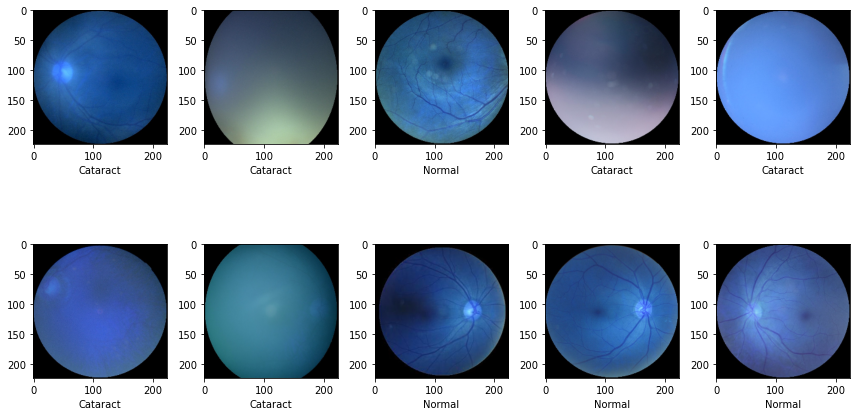

In [18]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()   

><h3>Dividing dataset into x(features) & y(target)</h3>

In [19]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [20]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

><h3>Creating Model</h3>

In [21]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [22]:
for layer in vgg.layers:
    layer.trainable = False

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [25]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,save_freq=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [27]:
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
28/28 [==============================] - 1005s 36s/step - loss: 1.6518 - accuracy: 0.8842 - val_loss: 1.7510 - val_accuracy: 0.9224
Epoch 2/15
28/28 [==============================] - 526s 19s/step - loss: 0.6609 - accuracy: 0.9461 - val_loss: 0.8384 - val_accuracy: 0.9178
Epoch 3/15
28/28 [==============================] - 524s 19s/step - loss: 0.1226 - accuracy: 0.9805 - val_loss: 0.7799 - val_accuracy: 0.9498
Epoch 4/15
28/28 [==============================] - 533s 19s/step - loss: 0.0662 - accuracy: 0.9885 - val_loss: 0.5599 - val_accuracy: 0.9589
Epoch 5/15
28/28 [==============================] - 550s 20s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.5153 - val_accuracy: 0.9589
Epoch 6/15
28/28 [==============================] - 512s 18s/step - loss: 9.8943e-05 - accuracy: 1.0000 - val_loss: 0.5165 - val_accuracy: 0.9589
Epoch 7/15
28/28 [==============================] - 499s 18s/step - loss: 6.3065e-05 - accuracy: 1.0000 - val_loss: 0.5189 - val_accuracy: 0.95

In [28]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 56s 8s/step - loss: 0.5312 - accuracy: 0.9589
loss: 0.5312000513076782
Accuracy: 0.9589040875434875


In [29]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
#y_pred_classes = model.predict_classes(x_test)
y_pred = (model.predict(x_test) > 0.5).astype("int32")

In [30]:
accuracy_score(y_test,y_pred)

0.958904109589041

In [31]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95        97
           1       0.97      0.96      0.96       122

    accuracy                           0.96       219
   macro avg       0.96      0.96      0.96       219
weighted avg       0.96      0.96      0.96       219



In [32]:
pip install mlxtend

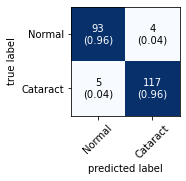

In [33]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(3,2),class_names = ["Normal","Cataract"],
                      show_normed = True);

><h3>Learning Curve</h3>

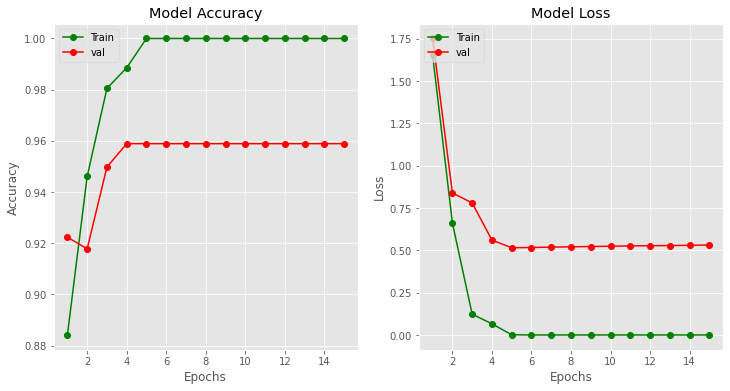

In [34]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

><h3>Prediction:</h3>

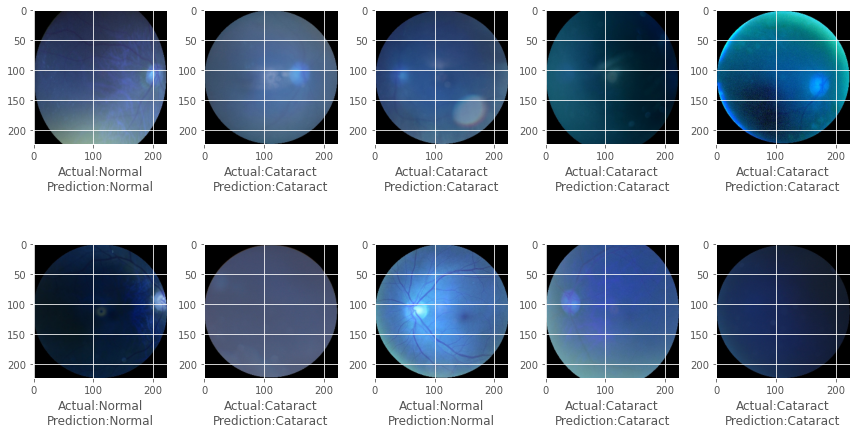

In [35]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    if pred_category== 0:
        pred_label = "Normal"
    # elif pred_category<0:
    #     pred_label = "Moderate"
    else:
        pred_label = "Cataract"
        
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 

---

<h1 style="text-align: center;font-size: 20px;">Thanks for Reading!!</h1>

---